In [1]:
from __future__ import division, print_function
from importlib import reload

In [2]:
import abstention
reload(abstention)
reload(abstention.calibration)
reload(abstention.label_shift)
from abstention.calibration import TempScaling, ConfusionMatrix, softmax
from abstention.label_shift import EMImbalanceAdapter, BBSEImbalanceAdapter, ShiftWeightFromImbalanceAdapter
import glob
import gzip
import numpy as np
from scipy.spatial import distance
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

def read_labels(fh):
    to_return = []
    for line in fh:
        the_class=int(line.rstrip())
        to_add = np.zeros(10)
        to_add[the_class] = 1
        to_return.append(to_add)
    return np.array(to_return)

def read_preds(fh):
    return np.array([[float(x) for x in y.decode("utf-8").rstrip().split("\t")]
                     for y in fh])

In [3]:
valid_labels = read_labels(gzip.open(glob.glob("valid_labels.txt.gz")[0]))
test_labels = read_labels(gzip.open(glob.glob("test_labels.txt.gz")[0]))
calibrator_factory=TempScaling(verbose=False)
bc_calibrator_factory=TempScaling(verbose=False, bias_positions=[0,1,2,3,4,5,6,7,8,9])
softmax_diffs = []
ts_diffs = []
bcts_diffs = []
softmax_js = []
ts_js = []
bcts_js = []

In [4]:
for seed in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]: 
    valid_preacts = read_preds(gzip.open(glob.glob("cifar10_balanced_seed-"+str(seed)+"_*validpreds.txt.gz")[0]))
    test_preacts = read_preds(gzip.open(glob.glob("cifar10_balanced_seed-"+str(seed)+"_*testpreds.txt.gz")[0]))
    test_preds = softmax(preact=test_preacts,temp=1, biases=None)
    func = calibrator_factory(valid_preacts, valid_labels)
    temp_scaled_preds = func(test_preacts)
    bcfunc = bc_calibrator_factory(valid_preacts, valid_labels)
    bcts_preds = bcfunc(test_preacts)
    softmax_diffs.append(np.max(np.abs(np.mean(test_preds, axis = 0)-np.mean(test_labels, axis = 0))))
    ts_diffs.append(np.max(np.abs(np.mean(temp_scaled_preds, axis = 0)-np.mean(test_labels, axis = 0))))
    bcts_diffs.append(np.max(np.abs(np.mean(bcts_preds, axis = 0)-np.mean(test_labels, axis = 0))))
    softmax_js.append(distance.jensenshannon(np.mean(test_preds, axis = 0),np.mean(test_labels, axis = 0)))
    ts_js.append(distance.jensenshannon(np.mean(temp_scaled_preds, axis = 0),np.mean(test_labels, axis = 0)))
    bcts_js.append(distance.jensenshannon(np.mean(bcts_preds, axis = 0),np.mean(test_labels, axis = 0)))

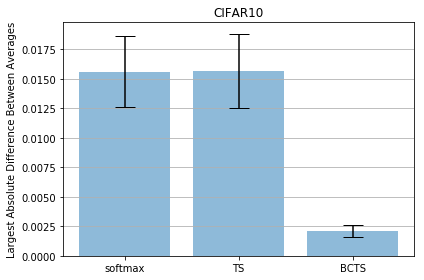

In [5]:
x = np.arange(3)
methods = ['softmax', 'TS', 'BCTS']
y = [np.mean(np.array(softmax_diffs)), np.mean(np.array(ts_diffs)), np.mean(np.array(bcts_diffs))]
error = [np.std(np.array(softmax_diffs)), np.std(np.array(ts_diffs)), np.std(np.array(bcts_diffs))]
fig, ax = plt.subplots()

ax.bar(x, y, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Largest Absolute Difference Between Averages')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.set_title('CIFAR10')
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

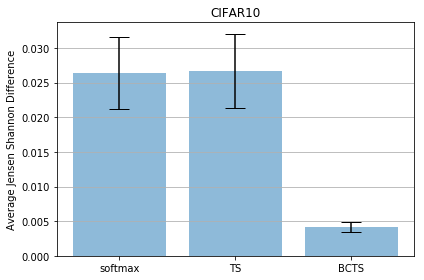

In [6]:
x = np.arange(3)
methods = ['softmax', 'TS', 'BCTS']
y = [np.mean(np.array(softmax_js)), np.mean(np.array(ts_js)), np.mean(np.array(bcts_js))]
error = [np.std(np.array(softmax_js)), np.std(np.array(ts_js)), np.std(np.array(bcts_js))]
fig, ax = plt.subplots()

ax.bar(x, y, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Average Jensen Shannon Difference')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.set_title('CIFAR10')
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()